In [1]:
# import nltk
# nltk.download()
from nltk.corpus import stopwords 
import numpy as np
import pandas as pd

stop = set(stopwords.words('russian'))
data = pd.read_csv("../data/train.csv",usecols=['title','description'])

In [2]:
data.head()

,title,description
0,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц..."
1,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика."
2,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ..."
3,Автокресло,Продам кресло от0-25кг
4,"ВАЗ 2110, 2003",Все вопросы по телефону.


## Word2Vec
Word2Vec is an efficient solution to these problems, which leverages the context of the target words. Essentially, we want to use the surrounding words to represent the target words with a Neural Network whose hidden layer encodes the word representation.

There are two types of Word2Vec, Skip-gram and Continuous Bag of Words (CBOW). I will briefly describe how these two methods work in the following paragraphs.

### Skip-gram
For skip-gram, the input is the target word, while the outputs are the words surrounding the target words. For instance, in the sentence “I have a cute dog”, the input would be “a”, whereas the output is “I”, “have”, “cute”, and “dog”, assuming the window size is 5. All the input and output data are of the same dimension and one-hot encoded. The network contains 1 hidden layer whose dimension is equal to the embedding size, which is smaller than the input/ output vector size. At the end of the output layer, a softmax activation function is applied so that each element of the output vector describes how likely a specific word will appear in the context. The graph below visualizes the network structure.
![image](https://cdn-images-1.medium.com/max/1600/1*TbjQNQLuyEW-cgsofyDioQ.png)
The word embedding for the target words can obtained by extracting the hidden layers after feeding the one-hot representation of that word into the network.

With skip-gram, the representation dimension decreases from the vocabulary size (V) to the length of the hidden layer (N). Furthermore, the vectors are more “meaningful” in terms of describing the relationship between words. The vectors obtained by subtracting two related words sometimes express a meaningful concept such as gender or verb tense, as shown in the following figure (dimensionality reduced).
![image](https://cdn-images-1.medium.com/max/1600/1*jpnKO5X0Ii8PVdQYFO2z1Q.png)

### CBOW
Continuous Bag of Words (CBOW) is very similar to skip-gram, except that it swaps the input and output. The idea is that given a context, we want to know which word is most likely to appear in it.
![image](https://cdn-images-1.medium.com/max/1600/1*UdLFo8hgsX0a1NKKuf_n9Q.png)
The biggest difference between Skip-gram and CBOW is that the way the word vectors are generated. For CBOW, all the examples with the target word as target are fed into the networks, and taking the average of the extracted hidden layer. For example, assume we only have two sentences, “He is a nice guy” and “She is a wise queen”. To compute the word representation for the word “a”, we need to feed in these two examples, “He is nice guy”, and “She is wise queen” into the Neural Network and take the average of the value in the hidden layer. Skip-gram only feed in the one and only one target word one-hot vector as input.

It is claimed that Skip-gram tends to do better in rare words. Nevertheless, the performance of Skip-gram and CBOW are generally similar.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

import pickle 
#import mglearn
import time


from nltk.tokenize import TweetTokenizer # doesn't split at apostrophes
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
txt = data.description.values[:10]
txt

array(['Кокон для сна малыша,пользовались меньше месяца.цвет серый',
       'Стойка для одежды, под вешалки. С бутика.',
       'В хорошем состоянии, домашний кинотеатр с blu ray, USB. Если настроить, то работает смарт тв /\nТорг',
       'Продам кресло от0-25кг', 'Все вопросы по телефону.',
       'В хорошем состоянии',
       'Электро водонагреватель накопительный на 100 литров Термекс ID 100V, плоский, внутренний бак из нержавейки, 2 кВт, б/у 2 недели, на гарантии.',
       'Бойфренды в хорошем состоянии.', '54 раз мер очень удобное',
       'По стельке 15.5см мерить приокский район. Цвет темнее чем на фото'], dtype=object)

In [7]:
# Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words=stop, analyzer='word', encoding='KOI8-R',
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

# Transforms the data into a bag of words
count_train = count_vec.fit(txt)
bag_of_words = count_vec.transform(txt)

# Print the first 10 features of the count_vec
print("Every feature:\n{}".format(count_vec.get_feature_names()))
print("\nEvery 3rd feature:\n{}".format(count_vec.get_feature_names()[::3]))

Every feature:
['100', '100v', '15', '25кг', '54', '5см', 'blu', 'id', 'ray', 'usb', 'бак', 'бойфренды', 'бутика', 'вешалки', 'внутренний', 'водонагреватель', 'вопросы', 'гарантии', 'домашний', 'квт', 'кинотеатр', 'кокон', 'кресло', 'литров', 'малыша', 'меньше', 'мер', 'мерить', 'месяца', 'накопительный', 'настроить', 'недели', 'нержавейки', 'одежды', 'от0', 'очень', 'плоский', 'пользовались', 'приокский', 'продам', 'работает', 'район', 'серый', 'смарт', 'сна', 'состоянии', 'стельке', 'стойка', 'тв', 'телефону', 'темнее', 'термекс', 'торг', 'удобное', 'фото', 'хорошем', 'цвет', 'электро']

Every 3rd feature:
['100', '25кг', 'blu', 'usb', 'бутика', 'водонагреватель', 'домашний', 'кокон', 'малыша', 'мерить', 'настроить', 'одежды', 'плоский', 'продам', 'серый', 'состоянии', 'тв', 'термекс', 'фото', 'электро']


In [8]:
print("Vocabulary size: {}".format(len(count_train.vocabulary_)))
print("Vocabulary content:\n {}".format(count_train.vocabulary_))

Vocabulary size: 58
Vocabulary content:
 {'кокон': 21, 'сна': 44, 'малыша': 24, 'пользовались': 37, 'меньше': 25, 'месяца': 28, 'цвет': 56, 'серый': 42, 'стойка': 47, 'одежды': 33, 'вешалки': 13, 'бутика': 12, 'хорошем': 55, 'состоянии': 45, 'домашний': 18, 'кинотеатр': 20, 'blu': 6, 'ray': 8, 'usb': 9, 'настроить': 30, 'работает': 40, 'смарт': 43, 'тв': 48, 'торг': 52, 'продам': 39, 'кресло': 22, 'от0': 34, '25кг': 3, 'вопросы': 16, 'телефону': 49, 'электро': 57, 'водонагреватель': 15, 'накопительный': 29, '100': 0, 'литров': 23, 'термекс': 51, 'id': 7, '100v': 1, 'плоский': 36, 'внутренний': 14, 'бак': 10, 'нержавейки': 32, 'квт': 19, 'недели': 31, 'гарантии': 17, 'бойфренды': 11, '54': 4, 'мер': 26, 'очень': 35, 'удобное': 53, 'стельке': 46, '15': 2, '5см': 5, 'мерить': 27, 'приокский': 38, 'район': 41, 'темнее': 50, 'фото': 54}


### N-grams
#### N=2

In [9]:
count_vec = CountVectorizer(stop_words=stopwords.words('russian'), analyzer='word', encoding='KOI8-R',
                            ngram_range=(1, 2), max_df=1.0, min_df=1, max_features=None)

count_train = count_vec.fit(txt)
bag_of_words = count_vec.transform(txt)

print(count_vec.get_feature_names())

['100', '100 литров', '100v', '100v плоский', '15', '15 5см', '25кг', '54', '54 мер', '5см', '5см мерить', 'blu', 'blu ray', 'id', 'id 100v', 'ray', 'ray usb', 'usb', 'usb настроить', 'бак', 'бак нержавейки', 'бойфренды', 'бойфренды хорошем', 'бутика', 'вешалки', 'вешалки бутика', 'внутренний', 'внутренний бак', 'водонагреватель', 'водонагреватель накопительный', 'вопросы', 'вопросы телефону', 'гарантии', 'домашний', 'домашний кинотеатр', 'квт', 'квт недели', 'кинотеатр', 'кинотеатр blu', 'кокон', 'кокон сна', 'кресло', 'кресло от0', 'литров', 'литров термекс', 'малыша', 'малыша пользовались', 'меньше', 'меньше месяца', 'мер', 'мер очень', 'мерить', 'мерить приокский', 'месяца', 'месяца цвет', 'накопительный', 'накопительный 100', 'настроить', 'настроить работает', 'недели', 'недели гарантии', 'нержавейки', 'нержавейки квт', 'одежды', 'одежды вешалки', 'от0', 'от0 25кг', 'очень', 'очень удобное', 'плоский', 'плоский внутренний', 'пользовались', 'пользовались меньше', 'приокский', 'прио

#### N=3

In [10]:
count_vec = CountVectorizer(stop_words=stopwords.words('russian'), analyzer='word', encoding='KOI8-R',
                            ngram_range=(1, 3), max_df=1.0, min_df=1, max_features=None)

count_train = count_vec.fit(txt)
bag_of_words = count_vec.transform(txt)

print(count_vec.get_feature_names())

['100', '100 литров', '100 литров термекс', '100v', '100v плоский', '100v плоский внутренний', '15', '15 5см', '15 5см мерить', '25кг', '54', '54 мер', '54 мер очень', '5см', '5см мерить', '5см мерить приокский', 'blu', 'blu ray', 'blu ray usb', 'id', 'id 100v', 'id 100v плоский', 'ray', 'ray usb', 'ray usb настроить', 'usb', 'usb настроить', 'usb настроить работает', 'бак', 'бак нержавейки', 'бак нержавейки квт', 'бойфренды', 'бойфренды хорошем', 'бойфренды хорошем состоянии', 'бутика', 'вешалки', 'вешалки бутика', 'внутренний', 'внутренний бак', 'внутренний бак нержавейки', 'водонагреватель', 'водонагреватель накопительный', 'водонагреватель накопительный 100', 'вопросы', 'вопросы телефону', 'гарантии', 'домашний', 'домашний кинотеатр', 'домашний кинотеатр blu', 'квт', 'квт недели', 'квт недели гарантии', 'кинотеатр', 'кинотеатр blu', 'кинотеатр blu ray', 'кокон', 'кокон сна', 'кокон сна малыша', 'кресло', 'кресло от0', 'кресло от0 25кг', 'литров', 'литров термекс', 'литров термекс i

### Min_df
Min_df ignores terms that have a document frequency (presence in % of documents) strictly lower than the given threshold. For example, Min_df=0.66 requires that a term appear in 66% of the docuemnts for it to be considered part of the vocabulary.

In [11]:
count_vec = CountVectorizer(stop_words=stopwords.words('russian'), analyzer='word', encoding='KOI8-R',
                            ngram_range=(1, 1), max_df=1.0, min_df=0.3, max_features=None)

count_train = count_vec.fit(txt)
bag_of_words = count_vec.transform(txt)

print(count_vec.get_feature_names())
print("\nOnly 'park' becomes the vocabulary of the document term matrix (dtm) because it appears in 2 out of 3 documents, \
meaning 0.66% of the time.\
      \nThe rest of the words such as 'big' appear only in 1 out of 3 documents, meaning 0.33%. which is why they don't appear")

['состоянии', 'хорошем']

Only 'park' becomes the vocabulary of the document term matrix (dtm) because it appears in 2 out of 3 documents, meaning 0.66% of the time.      
The rest of the words such as 'big' appear only in 1 out of 3 documents, meaning 0.33%. which is why they don't appear


### Max_df
When building the vocabulary, it ignores terms that have a document frequency strictly higher than the given threshold. This could be used to exclude terms that are too frequent and are unlikely to help predict the label. For example, by analyzing reviews on the movie Lion King, the term 'Lion' might appear in 90% of the reviews (documents), in which case, we could consider establishing Max_df=0.89

In [12]:
count_vec = CountVectorizer(stop_words=stopwords.words('russian'), analyzer='word', encoding='KOI8-R',
                            ngram_range=(1, 1), max_df=0.50, min_df=1, max_features=None)

count_train = count_vec.fit(txt)
bag_of_words = count_vec.transform(txt)

print(count_vec.get_feature_names())

['100', '100v', '15', '25кг', '54', '5см', 'blu', 'id', 'ray', 'usb', 'бак', 'бойфренды', 'бутика', 'вешалки', 'внутренний', 'водонагреватель', 'вопросы', 'гарантии', 'домашний', 'квт', 'кинотеатр', 'кокон', 'кресло', 'литров', 'малыша', 'меньше', 'мер', 'мерить', 'месяца', 'накопительный', 'настроить', 'недели', 'нержавейки', 'одежды', 'от0', 'очень', 'плоский', 'пользовались', 'приокский', 'продам', 'работает', 'район', 'серый', 'смарт', 'сна', 'состоянии', 'стельке', 'стойка', 'тв', 'телефону', 'темнее', 'термекс', 'торг', 'удобное', 'фото', 'хорошем', 'цвет', 'электро']

Only 'park' is ignored because it appears in 2 out of 3 documents, meaning 0.66% of the time.


### Max_features

In [13]:
count_vec = CountVectorizer(stop_words=stopwords.words('russian'), analyzer='word', encoding='KOI8-R',
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=4)

count_train = count_vec.fit(txt)
bag_of_words = count_vec.transform(txt)

print(count_vec.get_feature_names())

['настроить', 'состоянии', 'хорошем', 'цвет']


### TF-IDF

In [27]:
txt = data.description.values[10:30].astype(str).tolist()
txt

['Сдается однокомнатная мебелированная квартира квартира. Ежемесячная плата 18 тыс.р. + свет.',
 'nan',
 'Атлас история нового времени,19 век./\nКонтурные карты история нового времени,19 век./\nКонтурные карты по Географии./\nЦена указана за один товар.',
 'Продам манитор 18.5 v193HQV. В хорошем состоянии',
 'родились 1 февраля,три кобеля и сучка.',
 'Одето 1 раз на пару часов. Длина 79. Можно кормящим грудью мамочкам. Очень удобно. Платье с пришивным пояском и карманами. Декорировано змейкой на груди. На вид-совершенно новое платье. Цвет темно синий.',
 'Кондиционер, гидроусилитель руля, электрические стеклоподъемники. Мотор как  на Opel. Дополнительно установлена сигнализация./\nПТС оригинал, 3 хозяина, машина местная./\nМашина полностью на ходу, технически все исправно. /\nДокументы в порядке. /\nКузов не гнилой и не ржавый, машина не билась, но есть недочеты видные на фото. /\nЦена адекватная, торг минимальный./\nОсмотр в Краснодаре, в районе нового стадиона по ул. Восточно- Кругли

In [29]:
tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word',
                     stop_words=stopwords.words('russian'), encoding='KOI8-R')
txt_fitted = tf.fit(txt)
txt_transformed = txt_fitted.transform(txt)
print ("The text: ", txt)
print ("The txt_transformed: ", txt_transformed)

The text:  ['Сдается однокомнатная мебелированная квартира квартира. Ежемесячная плата 18 тыс.р. + свет.', 'nan', 'Атлас история нового времени,19 век./\nКонтурные карты история нового времени,19 век./\nКонтурные карты по Географии./\nЦена указана за один товар.', 'Продам манитор 18.5 v193HQV. В хорошем состоянии', 'родились 1 февраля,три кобеля и сучка.', 'Одето 1 раз на пару часов. Длина 79. Можно кормящим грудью мамочкам. Очень удобно. Платье с пришивным пояском и карманами. Декорировано змейкой на груди. На вид-совершенно новое платье. Цвет темно синий.', 'Кондиционер, гидроусилитель руля, электрические стеклоподъемники. Мотор как  на Opel. Дополнительно установлена сигнализация./\nПТС оригинал, 3 хозяина, машина местная./\nМашина полностью на ходу, технически все исправно. /\nДокументы в порядке. /\nКузов не гнилой и не ржавый, машина не билась, но есть недочеты видные на фото. /\nЦена адекватная, торг минимальный./\nОсмотр в Краснодаре, в районе нового стадиона по ул. Восточно- К

In [30]:
tf.vocabulary_

{'сдается': 189,
 'однокомнатная': 140,
 'мебелированная': 117,
 'квартира': 85,
 'ежемесячная': 68,
 'плата': 156,
 '18': 9,
 'тыс': 221,
 'свет': 188,
 'nan': 21,
 'атлас': 27,
 'история': 80,
 'нового': 132,
 'времени': 46,
 '19': 10,
 'век': 40,
 'контурные': 96,
 'карты': 83,
 'географии': 51,
 'цена': 238,
 'указана': 224,
 'товар': 217,
 'продам': 168,
 'манитор': 114,
 'v193hqv': 23,
 'хорошем': 235,
 'состоянии': 202,
 'родились': 181,
 'февраля': 229,
 'кобеля': 90,
 'сучка': 210,
 'одето': 139,
 'пару': 152,
 'часов': 241,
 'длина': 64,
 '79': 20,
 'кормящим': 98,
 'грудью': 56,
 'мамочкам': 113,
 'очень': 148,
 'удобно': 223,
 'платье': 157,
 'пришивным': 166,
 'пояском': 165,
 'карманами': 81,
 'декорировано': 61,
 'змейкой': 75,
 'груди': 55,
 'вид': 41,
 'совершенно': 200,
 'новое': 133,
 'цвет': 237,
 'темно': 213,
 'синий': 194,
 'кондиционер': 95,
 'гидроусилитель': 52,
 'руля': 185,
 'электрические': 246,
 'стеклоподъемники': 205,
 'мотор': 123,
 'opel': 22,
 'дополн

In [34]:
idf = tf.idf_
print(dict(zip(txt_fitted.get_feature_names(), idf)))

{'10': 3.9957322735539909, '100': 3.9957322735539909, '1050': 3.9957322735539909, '1100': 3.9957322735539909, '1150': 3.9957322735539909, '1250': 3.9957322735539909, '1400': 3.9957322735539909, '15': 3.9957322735539909, '170': 3.9957322735539909, '18': 3.3025850929940459, '19': 3.9957322735539909, '20': 3.3025850929940459, '37': 3.9957322735539909, '40': 3.9957322735539909, '46': 3.9957322735539909, '53': 3.9957322735539909, '56': 3.9957322735539909, '5до': 3.9957322735539909, '600': 3.9957322735539909, '75': 3.9957322735539909, '79': 3.9957322735539909, 'nan': 3.9957322735539909, 'opel': 3.9957322735539909, 'v193hqv': 3.9957322735539909, 'абс': 3.9957322735539909, 'агентства': 3.9957322735539909, 'адекватная': 3.9957322735539909, 'атлас': 3.9957322735539909, 'балкон': 3.9957322735539909, 'беспокоить': 3.9957322735539909, 'билась': 3.9957322735539909, 'блох': 3.9957322735539909, 'ботинки': 3.9957322735539909, 'бравекто': 3.9957322735539909, 'бумага': 3.9957322735539909, 'бусы': 3.99573

In [33]:
rr = dict(zip(txt_fitted.get_feature_names(), idf))
rr

{'10': 3.9957322735539909,
 '100': 3.9957322735539909,
 '1050': 3.9957322735539909,
 '1100': 3.9957322735539909,
 '1150': 3.9957322735539909,
 '1250': 3.9957322735539909,
 '1400': 3.9957322735539909,
 '15': 3.9957322735539909,
 '170': 3.9957322735539909,
 '18': 3.3025850929940459,
 '19': 3.9957322735539909,
 '20': 3.3025850929940459,
 '37': 3.9957322735539909,
 '40': 3.9957322735539909,
 '46': 3.9957322735539909,
 '53': 3.9957322735539909,
 '56': 3.9957322735539909,
 '5до': 3.9957322735539909,
 '600': 3.9957322735539909,
 '75': 3.9957322735539909,
 '79': 3.9957322735539909,
 'nan': 3.9957322735539909,
 'opel': 3.9957322735539909,
 'v193hqv': 3.9957322735539909,
 'абс': 3.9957322735539909,
 'агентства': 3.9957322735539909,
 'адекватная': 3.9957322735539909,
 'атлас': 3.9957322735539909,
 'балкон': 3.9957322735539909,
 'беспокоить': 3.9957322735539909,
 'билась': 3.9957322735539909,
 'блох': 3.9957322735539909,
 'ботинки': 3.9957322735539909,
 'бравекто': 3.9957322735539909,
 'бумага': 3

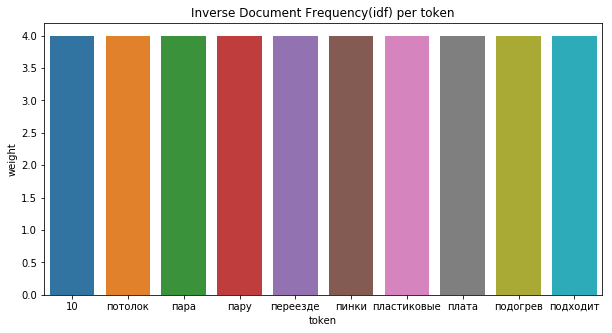

In [35]:
token_weight = pd.DataFrame.from_dict(rr, orient='index').reset_index()
token_weight.columns=('token','weight')
token_weight = token_weight.sort_values(by='weight', ascending=False)[:10]
token_weight

sns.barplot(x='token', y='weight', data=token_weight)
plt.title("Inverse Document Frequency(idf) per token")
fig=plt.gcf()
fig.set_size_inches(10,5)
fig.set_figwidth(10)
plt.show()

In [36]:
# get feature names
feature_names = np.array(tf.get_feature_names())
sorted_by_idf = np.argsort(tf.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:3]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-3:]]))

Features with lowest idf:
['торг' 'очень' 'состоянии']

Features with highest idf:
['комплекте' 'дизайнерским' 'эсп']


In [38]:
data.description.values[132]

'Продам коляску.Состояние хорошее.Переносной конверт с твердым, ровным дном,перекидная ручка,регулируемая спинка,корзина для покупок.'

In [39]:
txt_transformed.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [41]:
new1 = tf.transform(txt)

# find maximum value for each of the features over all of dataset:
max_val = new1.max(axis=0).toarray().ravel()

#sort weights from smallest to biggest and extract their indices 
sort_by_tfidf = max_val.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sort_by_tfidf[:3]]))

print("\nFeatures with highest tfidf: \n{}".format(
      feature_names[sort_by_tfidf[-3:]]))

Features with lowest tfidf:
['торг' 'состоянии' 'очень']

Features with highest tfidf: 
['рублей' 'собак' 'кг']
